# 02806 Social Data Analysis and Visualisation
## Final project report

**Link to website: https://traficph.streamlit.app**

**Group 51**

Julius Olander, s203225

Astrid Machholm, s222228

## Introduction and motivation

This project investigates the development and patterns in bicycle usage across Copenhagen from 2009 to 2023 in light of the municipality's strategy to become carbon neutral. The analysis focuses on the amount of bicycle transport occurring in the city, patterns that might influence the future bicycle infrastructure, and the municipality's recourse allocation towards monitoring bicycle traffic. Hence, this project seeks to answer the following question:

*How does the use of different means of transportation develop over time, and is there a detectable difference in how traffic moves through different districts of Copenhagen?*

Understanding how people navigate the city offers insights into how the infrastructure can be further developed, enhancing both traffic efficiency and citizen enjoyment. We are investigating how the number of bikes and vehicles has changed/remained over the period and, finally—and maybe most interestingly—how these means of transportation are distributed in the city's regions through the spacial autocorrelation of such regions, known as the Moran's I.

Many data sources could provide high-quality insights into our research question, e.g., machine vision systems, road sensors, and user GPS data. However, these sources are often either expensive to deploy at scale, or the data simply isn't available to the public (like the user data from Hövding helmets used in a 2022 study by DTU researcher[2]). Therefore, a partial aim of our project is to try to provide insights with far more scarce but publically available data. Hence, the following analysis and visualizations use the Trafiktælling data set from Copenhagen Municipality[1]. The data set spans the period from 2009 to 2023. The data are manual traffic recordings on select roads throughout Copenhagen; some roads appear frequently in the data, while the majority only have one record in the entire data set. Each record in the data set describes multiple attributes; the location, counts, and date are the most relevant to our analysis.

The dataset is complex as it is both geospatial *and* temporal, providing multiple interesting possible insights, although also imposing challenges. The time series aspect makes analyzing all entries in the dataset as one inappropriate, and the geospatial component makes regional data sparse. Through our preprocessing and analysis, we try to account for these challenges. At the end of the report, we discuss the insights and shortcomings of our study, the data quality, and how this lends itself to the medium of visual narratives.

The end product (available on https://traficph.streamlit.app) aims to provide easily accessible information for a non-technical audience among the interested parties involved in achieving the municipality's environmental strategy. The intended audience includes municipality employees of varying backgrounds, focus groups, and more. Hence, the visualizations and context displayed on the website aim to be easily understood with little prior understanding of technical jargon and statistical terms despite including a statistical test rarely known by the general public.

To limit confusion between the two submitted websites as part of this course, we also provide the link to assignment 2's website: https://juliusolander.github.io/jekyll/update/2024/03/29/assignment-2.html

Sources:
- [1] https://www.opendata.dk/city-of-copenhagen/trafiktal
- [2] https://videnskab.dk/teknologi/vild-visualisering-forskere-har-kortlagt-cykeltrafikken-i-koebenhavn/

## Basic stats

In [1]:
# One block for all imports used in all sections of this notebook
import pandas as pd
import folium
import geopandas as gpd
from esda.moran import Moran
from libpysal.cg.voronoi import voronoi, voronoi_frames
from libpysal.weights import Queen
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import calplot

warnings.simplefilter("ignore")

In [2]:
# Select the relevant columns for the reqular dataframe
fname_df = "data/trafiktaelling.csv"
cols_df = ["aadt_koretojer", "aadt_cykler"]
feats_df = cols_df + ["vejnavn", "taelle_dato", "aar"]

# Select the relevant columns for the geopandas dataframe
fname_geo = "data/trafiktaelling.shp"
cols_geo = ["aadt_koret", "aadt_cykle"]
feats_geo = cols_geo + ["vejnavn", "taelle_dat", "geometry"]

In [3]:
def load_df_fn(f, feats):
    df = pd.read_csv(f)

    print("The shape of the raw data:", df.shape)
    print("\nAll features in the original data:\n", df.columns, "\n")
    
    df['taelle_dato'] = pd.to_datetime(df['taelle_dato'], format='%Y%m%d')

    print(df.describe(), "\n")
    
    df = df.drop([c for c in df.columns if c not in feats], axis=1).dropna(subset=['aadt_cykler']) # focus is on bikes, thus keeping entries that has bike recordings

    print("The shape of the cleaned data:", df.shape)
    
    return df

In [4]:
df = load_df_fn(fname_df, feats_df)

The shape of the raw data: (1147, 37)

All features in the original data:
 Index(['FID', 't_nr', 'vejnavn', 'beskrivelse', 'husnummer', 'type',
       'taelling_type', 'ktj_7_19', 'tung_pct', 'aadt_koretojer',
       'hvdt_koretojer', 'cykler_7_19', 'ladcykler_pct', 'aadt_cykler',
       'hvdt_cykler', 'fod_7_19', 'aadt_fod_7_19', 'hvdt_fod_7_19', 'fod_7_21',
       'aadt_fod_7_21', 'hvdt_fod_7_21', 'fod_7_24', 'aadt_fod_7_24',
       'hvdt_fod_7_24', 'aadt_fod_label', 'taelle_dato', 'aar', 'link',
       'tung_pct_real', 'ladcykler_pct_real', 'lastbiler_7_19',
       'lastbiler_pct', 'elloebehjul_7_19', 'elloebehjul_pct',
       'andre_busser_7_19', 'ogc_fid', 'wkb_geometry'],
      dtype='object') 

               t_nr         type      ktj_7_19  aadt_koretojer  \
count   1147.000000  1146.000000    580.000000      580.000000   
mean    5607.539669    83.382199   7204.093103     8431.379310   
min        1.000000     1.000000      0.000000        0.000000   
25%      767.500000     4

The data set is limited in size, with only 1147 rows. Its 37 attributes cover many interesting aspects, but only some are necessary for the question at hand. Many attributes have poorly explained names, and the data collection methods are often poorly documented.

_7_9 is written behind many attribute names to indicate that the count occurred between 07:00 and 19:00. The prefix "aadt" used on the recorded transportation types is short for the calculated Annual Average Daily Traffic. The data set provider does not explain the calculation method, but given that the municipality itself uses the measure, we deem it acceptable for our analysis. To account for the whole day rather than the window of the working hours (7:00 to 19:00), we only use "aadt". The documentation does not describe the other prefix ("hvdt"). Hence, we do not know what this means and must drop these attributes.

The exact date of the data collection is captured in "taelle_dato"; for simplicity, the column "aar" only contains the year. The exact location is captured in column "wkb_qoemetry". We use this attribute when defining the geopandas dataframe used in the analysis section.

Due to insufficient documentation from the data source, "beskrivelse" and "taelling_type" do not provide helpful information to understand the data better.

The data is categorized into three main types of transport: vehicles (referred to as 'ktj' or 'koretojer'), bicycles ('cykler'), and pedestrians ('fod'). Other types of vehicles, such as trucks, electric scooters, and buses, are also included. Our analysis only focuses on the most recorded types, namely cars and bicycles. As our project mainly focuses on bicycles as the strategy of the Copenhagen municipality, we keep all rows with bike recordings but accept a few missing data points in the cars.

Once the data is cleaned, we are left with 656 useful data entries spread across the years. The year column's mean in mid-2017 (slightly higher than the median value in 2016) indicates a slight right-skewed distribution in terms of the number of road observations performed.

<Axes: title={'center': 'Number of roads observed by year'}, xlabel='Year', ylabel='Count'>

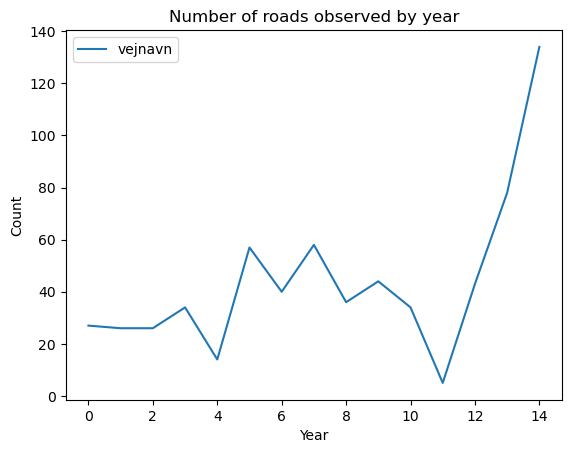

In [5]:
def observations_explor(df):
    yearly_counts = df.groupby(['aar']).count().reset_index()

    yearly_counts = yearly_counts.drop([c for c in yearly_counts.columns if c not in ['vejnavn']], axis=1)
    
    return yearly_counts.plot(xlabel="Year", ylabel="Count", title="Number of roads observed by year")

observations_explor(df)

There is an extreme increase in the number of road observations done by year since year 11 (Covid in 2020). This indicates an increased focus and resource allocation toward data collection, perhaps preparing for infrastructure investments.

   aadt_koretojer  aadt_cykler
0         76300.0      39900.0
1         59200.0      48500.0
2        125700.0      51000.0
3        270000.0     107600.0
4         73700.0      58200.0


<Axes: title={'center': 'Sum of observations by category by year'}>

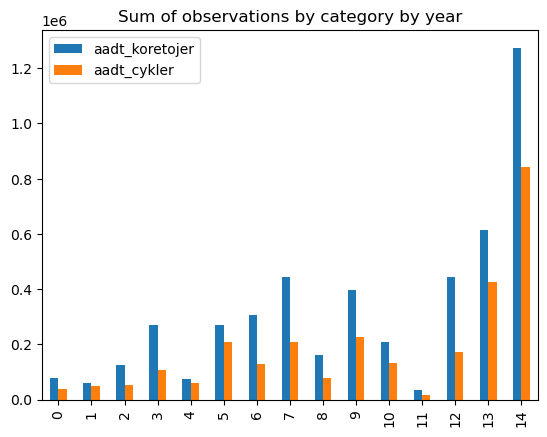

In [6]:
def total_counts_explor(df):
    yearly_counts = df.drop(['taelle_dato', 'vejnavn'], axis=1)
    yearly_counts = yearly_counts.groupby(['aar']).sum().reset_index()
    yearly_counts = yearly_counts.drop(['aar'], axis=1)

    print(yearly_counts.head())

    return yearly_counts.plot(kind='bar', title='Sum of observations by category by year')

total_counts_explor(df)

Not surprisingly, the number cars/bikes observed by year, follows the number roads observed as seen on the line chart directly above.

(<Figure size 700x1500 with 16 Axes>,
 array([<Axes: ylabel='2009'>, <Axes: ylabel='2010'>,
        <Axes: ylabel='2011'>, <Axes: ylabel='2012'>,
        <Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>], dtype=object))

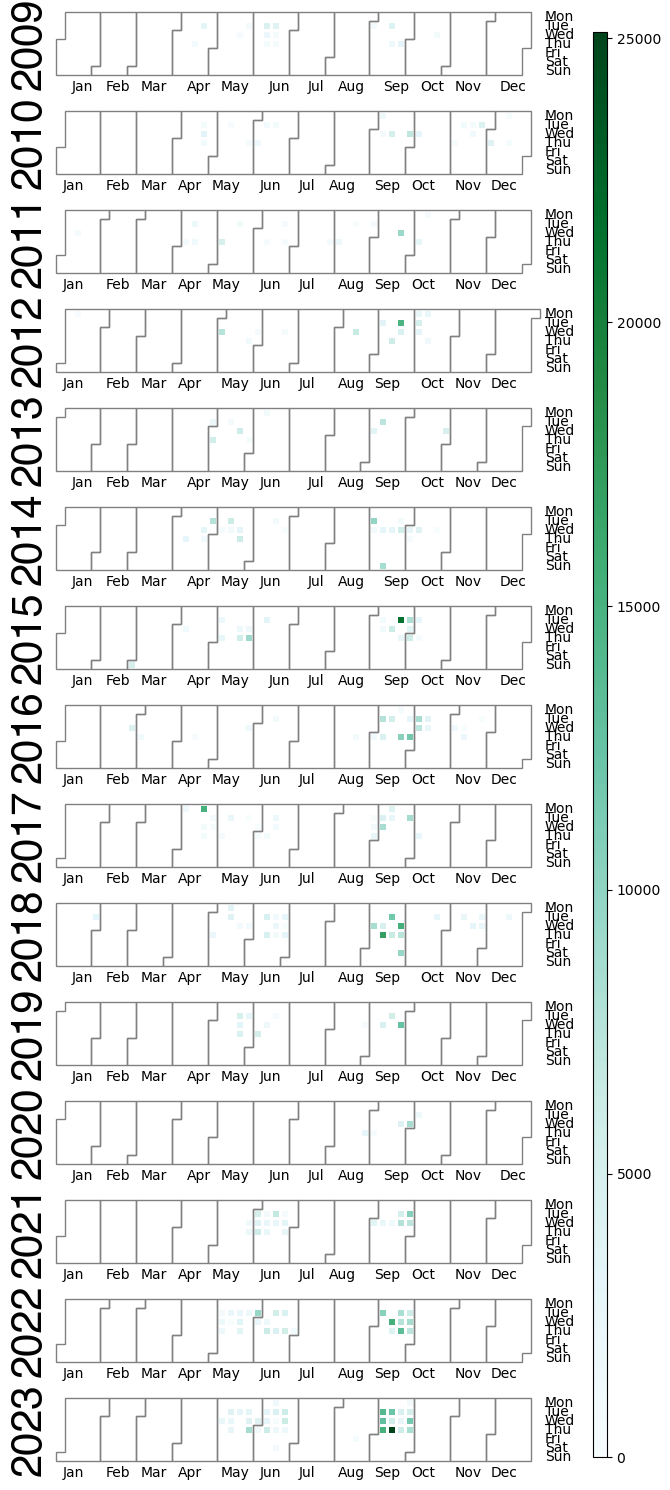

In [7]:
def calendar_explot(df, category={'aadt_cykler', 'aadt_koretojer'}):
    cal = df.groupby(['taelle_dato'])[category].mean()
    return calplot.calplot(cal, how='mean', cmap='BuGn', fillcolor='white', yearlabel_kws={'color': 'black'}, figsize=(7,15))

calendar_explot(df, 'aadt_cykler')

Judging from the calendar plot, there appears to be two yearly observation periods, May/June and September/October. The average number of observed bike per observation day is inreasing over time. This does not explain if there is an increased number of bikes in Copenhagen, or if they shifted to observe and count roads with heaver traffic.

vejnavn
Tagensvej             14
Frederikssundsvej      8
Jagtvej                8
Ørestads Boulevard     5
Vesterbrogade          5
Vejlands Allé          5
Hillerødgade           5
Tuborgvej              4
Strandboulevarden      4
Sølvgade               4
Islands Brygge         4
Guldbergsgade          4
Gothersgade            4
Valby Langgade         4
Øster Søgade           4
Name: count, dtype: int64


<Axes: title={'center': 'Number of times each road is observed'}, xlabel='vejnavn'>

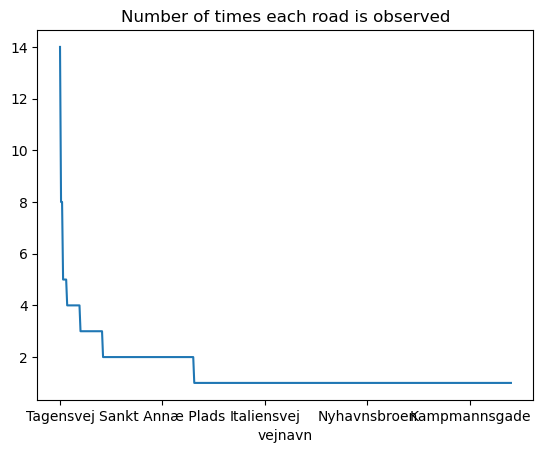

In [8]:
print(df.vejnavn.value_counts().head(15))
df.vejnavn.value_counts().plot(kind='line', title='Number of times each road is observed')

The number of times specific roads are observed veries largely. Tagensvej is observed 14 times in 14 years, Frederikssundsvej and Jagtvej have 8 observations each. From there, it quickly declines and the majority of roads are only observed once.

<Axes: title={'center': 'Frequency of the counts of bikes observed per road'}, xlabel='Count', ylabel='Frequency'>

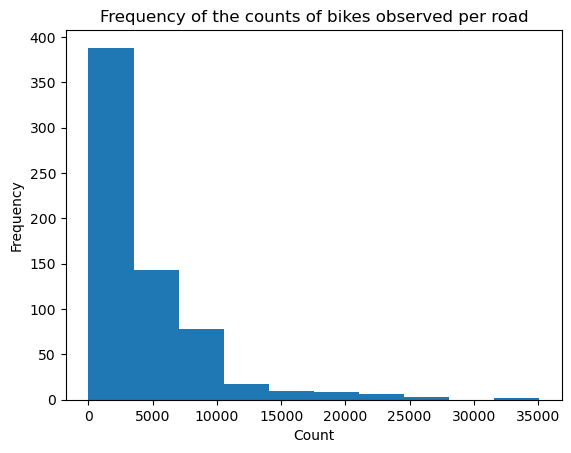

In [9]:
df.aadt_cykler.plot(kind='hist', xlabel='Count', title='Frequency of the counts of bikes observed per road')

<Axes: title={'center': 'Frequency of the counts of cars observed per road'}, xlabel='Count', ylabel='Frequency'>

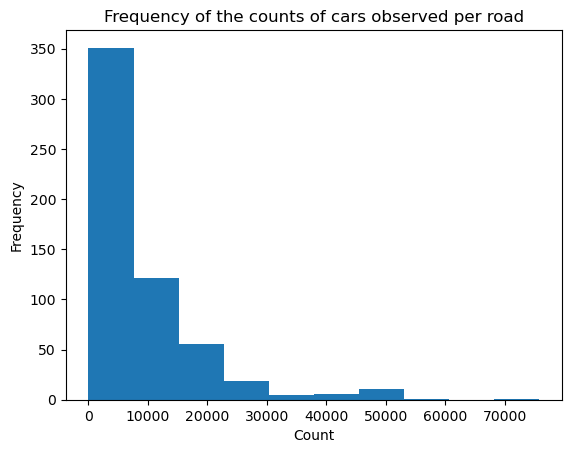

In [10]:
df.aadt_koretojer.plot(kind='hist', xlabel='Count', title='Frequency of the counts of cars observed per road')

Most roads have less than 10,000 bikes and less than 20,000 cars. The distribution for cars and bikes are similar, though cars are more frequent. It appears that one road has more than 70,000 cars in an observation.

<Axes: title={'center': 'Ratio of mean observed bikes of sum of mean observed bikes and cars by year'}, xlabel='Year', ylabel='Ratio'>

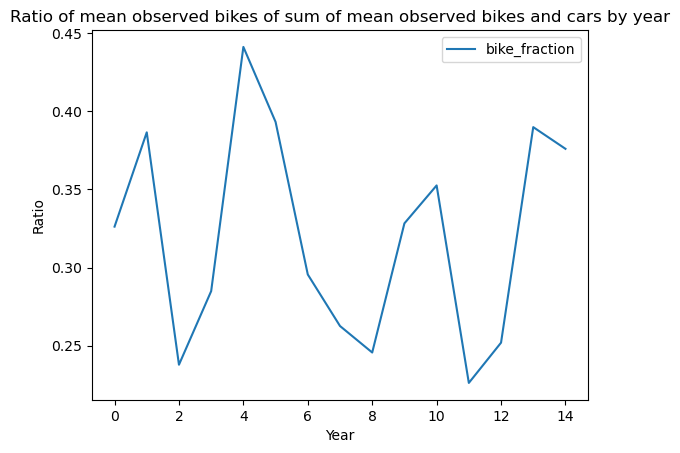

In [11]:
def ratio_explor(df):
    yearly_bikes = df.drop(['taelle_dato', 'vejnavn'], axis=1)
    yearly_bikes = yearly_bikes.groupby(['aar']).mean().reset_index()

    yearly_bikes['bike_fraction'] = yearly_bikes['aadt_cykler'] / (yearly_bikes['aadt_cykler'] + yearly_bikes['aadt_koretojer'])

    yearly_bikes = yearly_bikes.drop([c for c in yearly_bikes.columns if c not in ['bike_fraction']], axis=1)
    
    return yearly_bikes.plot(xlabel="Year", ylabel="Ratio", title="Ratio of mean observed bikes of sum of mean observed bikes and cars by year")

ratio_explor(df)

The ratio of mean bike observations to mean number of total observations (bikes + cars) per roads, fluctuates throughout the entire period. This indicates that the counting strategies from year to year is different. Some years they might make traffic observations on many roads primarily intended for bikes, the next year they may prioritise roads primarily intended for cars.

### Heatmap
In the heatmap below we take a quick look at where the most bike traffic occurs according to the traffic counts.

In [12]:
import folium
from folium import plugins

tc = pd.read_csv("data/trafiktaelling.csv")

# preprocessing
tc[['lon', 'lat']] = tc['wkb_geometry'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
tc = tc.drop('wkb_geometry', axis=1)
tc['lon'] = tc['lon'].astype(float)
tc['lat'] = tc['lat'].astype(float)


# extracting year
tc['taelle_dato'] = pd.to_datetime(tc['taelle_dato'], format='%Y%m%d')
tc['year'] = tc['taelle_dato'].dt.year
yearly_counts = tc.groupby(['year'])['cykler_7_19'].sum().reset_index()

# dropping NaNs
tc = tc.dropna(subset=['lat', 'lon', 'cykler_7_19'])

# create a map centered at the average location
map_center = [tc['lat'].mean(), tc['lon'].mean()]
cph_map = folium.Map(location=map_center, zoom_start=12)

# create a list of coordinates for the heatmap
heat_data = [[row['lat'], row['lon'], row['cykler_7_19']] for index, row in tc.iterrows()]

# add heat to the map
plugins.HeatMap(heat_data, radius=20, blur=20).add_to(cph_map)

cph_map

In the plot we do see, not suprisingly, that the most bike traffic (heat) occurs in the inner city area. However as we already discovered, the observations are highly dependent on where the municipality actually chooses to record. Judging from this plot, it does seem that throughout the years, they have actually managed to capture quite a broad span of locations, and the traffic seems in line with what one would expect.

## Data Analysis

There are many famous measures, most notably is probably mean, median, variance, and standard deviation. However, these measures fall short of describing phenomena like: _how_ does a given variable spread over a given shape/geography. Similar to the relationship between mean and median, various ways exist to answer this. We will focus on what is perhaps the simplest: Moran's I, to answer the question of how do bikes spread throughout the city. At one extreme, we would have bikes exclusively placed in a particular area; at another, we would have bikes spread out in small pockets. Understanding how this varies throughout the city of Copenhagen can help inform city planning decisions, explain why certain areas are better to bike in, hint at what spaces are most shared between people, and more. Moran's I thus becomes interesting for both the hypothetical city planner and, more importantly, the biking citizenry of Copenhagen.

The code block below defines all the functions used to calculate Moran's I. Below that is an explanation of each function and the choiceses made.

In [13]:
def load_geo_fn(f, feats):
    """
    this functions loads a shapefile and returns a geodataframe with only the columns specified.
    nan values are dropped.
    """
    gdf = gpd.read_file(f)
    gdf = gdf.drop([c for c in gdf.columns if c not in feats], axis=1).dropna()  # TODO:
    return burroughs_fn(gdf)


def voronoi_fn(gdf):
    """
    as the data consists of points, we can use voronoi to create regions around the points.
    this function returns the regions and the vertices of the voronoi diagram.
    """
    # regions, vertices = voronoi(gdf.geometry.apply(lambda x: (x.x, x.y)).tolist())
    points = gdf.geometry.apply(lambda x: (x.x, x.y)).tolist()
    region_df, points_df = voronoi_frames(points)
    return region_df  # , points_df


def morans_fn(gdf, col):
    """
    this function calculates the moran's I for a given column in the geodataframe.
    """
    w = Queen.from_dataframe(gdf)
    moran = Moran(gdf[col], w)
    return moran.I, moran.p_sim


def analysis_fn(gdf, bdf, cols):
    """
    computes the moran's I for each column in the geodataframe.
    """
    lst = []
    fn = lambda x: bdf[bdf["navn"] == x].iloc[0]["geometry"]
    for col in cols:
        for b in gdf["bydel"].unique():
            burrough_gdf = gdf[gdf["bydel"] == b]
            moran_I, moran_p = morans_fn(burrough_gdf, col)
            lst.append((col, b, moran_I, moran_p))
    df = pd.DataFrame(lst, columns=["column", "burrough", "moran_I", "p_value"])
    df["geometry"] = df["burrough"].apply(fn)
    return gpd.GeoDataFrame(df, geometry="geometry")


def burroughs_fn(gdf):
    """
    this function assigns each point in the geodataframe to a burrough.
    """
    bdf = gpd.read_file("data/bydele.geojson").to_crs(gdf.crs)
    # remove porints that are not in any burrough
    gdf = gdf[gdf.geometry.apply(lambda x: any(bdf["geometry"].contains(x)))]
    # assign each point to a burrough (use within)
    fn = lambda x: bdf[bdf["geometry"].contains(x)].iloc[0]["navn"]
    gdf["bydel"] = gdf.geometry.apply(fn)
    return gdf, bdf

In [14]:
gdf, bdf = load_geo_fn(fname_geo, feats_geo) if "gdf" not in locals() else eval("(gdf, bdf)")
adf = analysis_fn(gdf, bdf, cols_geo)

print("Analysis output:")
adf

Analysis output:


,column,burrough,moran_I,p_value,geometry
0,aadt_koret,Indre By,0.183773,0.002,"MULTIPOLYGON (((12.72897 55.70386, 12.72899 55..."
1,aadt_koret,Valby,-0.073204,0.343,"MULTIPOLYGON (((12.52434 55.66666, 12.52372 55..."
2,aadt_koret,Amager Vest,0.193254,0.015,"MULTIPOLYGON (((12.58271 55.66850, 12.58252 55..."
3,aadt_koret,Bispebjerg,0.046371,0.179,"MULTIPOLYGON (((12.53830 55.72644, 12.53822 55..."
4,aadt_koret,Brønshøj-Husum,-0.156348,0.119,"MULTIPOLYGON (((12.46894 55.69975, 12.46935 55..."
5,aadt_koret,Vanløse,-0.033997,0.480,"MULTIPOLYGON (((12.49820 55.68552, 12.49845 55..."
6,aadt_koret,Nørrebro,0.175926,0.003,"MULTIPOLYGON (((12.53704 55.69653, 12.53694 55..."
7,aadt_koret,Vesterbro-Kongens Enghave,0.038737,0.196,"MULTIPOLYGON (((12.54553 55.63972, 12.54677 55..."
8,aadt_koret,Østerbro,0.222116,0.002,"MULTIPOLYGON (((12.59777 55.70348, 12.59700 55..."
9,aadt_koret,Amager Øst,-0.051930,0.451,"MULTIPOLYGON (((12.63082 55.67057, 12.63079 55..."


#### Explanation of method and choices

Moran's I is one of the simplest measures to assess spatial autocorrelation. It can be thought of as whether it is more or less likely that a high value is surrounded by neighboring high values, and the same for low-value tiles.

To construct this measure, we first ensure that every observation has edges and corners meeting other observations. The observations in the data set are recorded at specific locations/points. The single points do not have neighbors and cannot be used directly for Moran's I. Likewise, the roads intersect at points but do not have neighboring edges all around; thus, we also cannot use the roads as tiles to determine Moran's I.

Instead, we construct tiles using the Voronoi algorithm so one observation is within each tile. The constructed tiles do not correspond correctly to real-world phenomena like streets or building blocks. They will, however, prove a neat tool in our visualizations.

To calculate the spatial autocorrelation, the Moran's I function takes both the geospatial data and some weights as input. The weights are calculated as "Queens"; in the chess game, the queen moves in all directions, and in our weight calculation we likewise consider neighbors that either share and edge *or* a corner with the tile in question.

The analysis function takes the dataset with the associated city districts to each observation. For each of the city districts, Moran's I is calculated. Thus, each district gets a value from -1 to 1 (from districts with tiles of high-value car/bike counts are surrounded by low values to the other extreme with clear sectioning of one part of the district with all bikes and the other with none).

We've made two specific choices that impact the analysis that we would like to highlight in the following:

Firstly, Copenhagen's subareas vary in terms of demography, whether businesses or private homes dominate them, whether they are part of the old city or a new construction, and more. Our intuition and experience tell us that these differences also impact traffic patterns. Thus, we find it relevant to subdivide the city. We use the ten districts as provided by the municipality in the dataset bydele.geojson. 

Secondly, we do not use the temporal component in the Moran's I analysis. This is an active choice as 1) if dividing the data into years, there would not be enough data in each district, and 2) big infrastructure changes take a long time, so we believe that the data might still be representative of the type of traffic occurring in the area.

This analysis is not perfect, and there are far more advanced methods to determine spatial autocorrelation, yet we still find it reasonable to use the simple Moran's I measure. As the data anyway isn't collected with this type of analysis in mind, whichever analysis we would perform of this kind would likely be imperfect. The simple measure can still indicate either a positive or a negative relationship within a region. It is relevant because it may spark ideas for interesting future analysis, which is relevant in a city like Copenhagen that is shifting its resource allocation and aiming towards a different kind of traffic.

The null hypothesis is that the observations are randomly distributed in the districts. The p-value for a single district is not quite representative, as we have divided the dataset/analysis into many smaller districts. To really use the p-values, we would have to adjust them according to the number of sub-analysis, e.g., with a Bonferroni adjustment, as several statistical tests are done on the same data set. Half of our observations have a non-rejectable p-value at a 0.05 level. Had there not been some pattern detectible by the Moran's I, we expect this fraction to be much lower. As our Moran's I analysis is mainly intended as a simple measure to spark further curiosity into traffic patterns around Copenhagen rather than an exact analysis intended directly for infrastructure planning and investments, we find it acceptable to go on using the measure as part of our visual narrative story.

#### Interpretation of the results

The Moran's I values seen in the table above all fall close to 0 regardless of category (car or bike), meaning traffic is still reasonably spread in smaller clusters within all districts. Interestingly, all negative values (signifying more spread traffic) are all in the districts furthest from the inner city. We cannot tell how much of this is due to choices in data collection and how much is due to the actual traffic patterns.

## Genre

The overall genre of our product is the *magazine style*. Our audience is mainly people working within the municipality, and we intend our product to be used as background information for decision-making. Thus, a format that combines text and visualizations was most appropriate. The genre is especially useful as the analysis (Moran's I parameter) we are communicating is rather technical for our audience. Hence, guidance and explanation are necessary to help the viewer gain valuable information from our analysis. Complicated and/or technical matters can be inaccessible to an untrained, general audience if presented solely in a written format or as visualizations that require preexisting knowledge. When combining the two mediums, an untrained viewer can quickly understand and use a new concept to draw new conclusions.

**Visual Narrative**

*Highlighting:* Our format only lends itself well to the feature distinction tool. We have used this in the form of different coloring. Likewise, the dual line chart utilizes a grey field highlighting a notable turning point, the Covid-19 pandemic.

*Visual structuring:* Due to the genre-specific communication method in the magazine style, we do not use any significant form of visual structuring. The text is the main guiding element for the reader. Hence, separate visual cues to guide the reader would be redundant or even disturbing to the reader who is processing new information and learning new technical measures.

*Transition guidance:* We do not use transition guidance for the same reasons that we do not use visual structuring. All our information is contained on one page; thus, the reader does not need cues to guide their attention from one scene to another; there simply aren't any significant transitions to be guided through.

**Narrative Structure**

*Ordering:* First and foremost, the structuring is linearly ordered in the sense that the viewer reads from the top and is, initially, expected to inspect the visualizations in the order they appear in the text. However, the format also allows for some random access; as the method used in the analysis will be new to many receivers of our product, we expect and invite the readers to revisit explanatory text as needed. An example of such an invitation is the information boxes explaining statistical methods.

*Interactivity:* The second visualization (the the bar chart) uses interactivity. This visualization differs from the first line chart in that the line chart needs to convey a few simple points, whereas the bar chart aims to provide more information about transport development over time. As this chart includes many categories, we allow the reader to highlight specific categories while being able to compare them to the others in the background.

*Messaging*: Our final product (the website) combines the visualizations with explanatory texts, reference articles, and other sources, and it uses annotations, introductory text, and a final synthesis.

## Visualizations

We have created three types of plots to tell our story. One dual plot line chart, an interactive bar chart, and a choropleth map. Each section first describes why we chose the respective plots and our specific data/design choises. The plots are displayed below each description.

### Dual plot line chart

We are analyzing traffic data in light of Copenhagen's strategy to reduce emissions from fossil fuels and noise pollution. To achieve the target, strategies include making it even easier and more comfortable to get around by bike and reducing car mobility in the city, e.g., through legislation (e.g., speed limits) and infrastructure planning.

Initially, we need to give our readers a sense of 1) how widespread the uses of the main transportation methods are, 2) the order of magnitude of such means of transportation, 3) how the strategy is prioritized in the municipality, and 3) if they are on track to achieving their aim of fewer cars in the city.

This is a lot of information to present, but our first visualization achieves all of this in one. We use averages to account for the inconsistency in the number of road observations performed yearly, making the observations comparable across years. With the upper line charts showing cars and bikes, it is clear that there are still many more cars than bikes across the city. We can also see an upward trend for both categories, indicating that there may be more bikes as the city wishes, but they are certainly not yet achieving the aim of fewer cars around the city.

The number of road observations done yearly is interesting, as it has more than doubled in the last few years. We do not know why this is, but a reasonable guess is to increase data collection to support the city's traffic strategy.

We chose to align the plots on top of each other with the same x-axis to allow the reader easy comparison and interpretation of the trends around the COVID-19 pandemic. We can see how the pandemic impacted public policy in that city allocated far fewer resources to road observations in 2020. At the same time, there is a notable development in the mean number of observed bikes, with a substantial negative development in biking immediately following Covid. This trend seemed to have kicked in already in 2019. However, we do not know if this is explained by the slight yearly fluctuations observed in the earlier years or if it is connected to the trend from 2020 onwards. Only further analysis might answer this.

Finally, cars occupy increasing road space, undisturbed by Covid, indicating that people take cars for any kind of transportation through the city. Bikes might, however, largely be used for work-related commuting as the decrease coincides with increased remote working.

The y-axis on the upper plot does not start at 0. We decided against this despite it looking a bit like a wrongful continuation of the y-axis below because the extra white space, if starting at 0, was visually disturbing, and we deemed the numbers on the two plots' y-axis sufficiently different for the readers to understand the difference.

In [15]:
def dual_plot(df):
    yearly_means = df.drop(['taelle_dato', 'vejnavn'], axis=1)
    yearly_means = yearly_means.groupby(['aar']).mean().reset_index()
    yearly_counts = df.groupby(['aar']).count().reset_index()

    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1.5]})

    f.set_figheight(8)
    f.set_figwidth(10)

    plt.suptitle('Mean observed number of bikes and cars per road by year', fontsize=14, x=0.6, y=0.99, horizontalalignment="right")
    a0.plot(yearly_means["aar"], yearly_means["aadt_cykler"], linewidth=4, label = "Bikes", color="black")
    a0.plot(yearly_means["aar"], yearly_means["aadt_koretojer"], linewidth=4, label = "Cars", color="grey")
    a0.legend(loc='upper left')

    # Highlight Civid-19 year
    highlight_start = 2019.5
    highlight_end = 2020.5
    a0.axvspan(highlight_start, highlight_end, color='grey', linestyle='-.', alpha=0.2)  # Add shaded rectangle

    # Add explanatory text box
    explanation = "Covid-19 pandemic started"
    a0.text(2019.85, 6600, explanation, fontsize=9, ha='left', va='center', rotation=270)
    
    
    #plt.xlim(2009, 2023)
    a0.set_xlim(2009, 2023)
    a0.set_xticks([])
    sns.despine()

    #a1.figure(figsize=(10, 2))
    a1.plot(yearly_counts["aar"], yearly_counts["aadt_cykler"], linewidth=4, label = "Number of roads observed", color="yellowgreen")
    a1.legend(loc='upper left')

    # Highlight Civid-19 year
    highlight_start = 2019.5  # Start year of the highlighted period
    highlight_end = 2020.5  # End year of the highlighted period
    a1.axvspan(highlight_start, highlight_end, color='grey', linestyle='-.', alpha=0.2)  # Add shaded rectangle
    
    a1.set_xlim(2009, 2023)
    sns.despine()

    f.supxlabel('Year')
    f.supylabel('Count')
    
    f.tight_layout()

    plt.savefig('plots/plot_dual.png')

    return plt

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

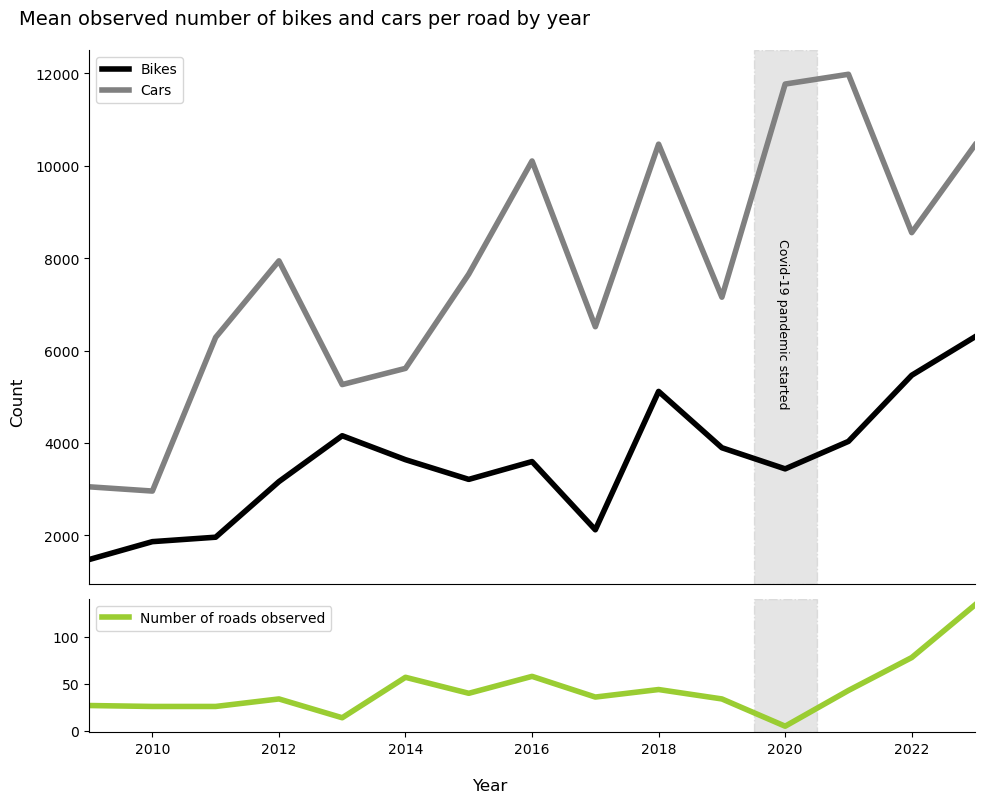

In [16]:
p = dual_plot(df)
p

### Bokeh plot

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

tc = pd.read_csv("data/trafiktaelling.csv")

# preprocessing
tc[['lon', 'lat']] = tc['wkb_geometry'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
tc = tc.drop('wkb_geometry', axis=1)
tc['lon'] = tc['lon'].astype(float)
tc['lat'] = tc['lat'].astype(float)


# extracting year
tc['taelle_dato'] = pd.to_datetime(tc['taelle_dato'], format='%Y%m%d')
tc['year'] = tc['taelle_dato'].dt.year
yearly_counts = tc.groupby(['year'])['cykler_7_19'].sum().reset_index()

First, the columns we are using to create the plot are extracted. Here we create a pivot table with years as rows and the select most regular transportation methods as columns. Then we normalize them so that their evolution can be compared on a similar scale, and rename them for better readability in the final plot.

In [18]:
vehicle_columns = [
    'hvdt_koretojer', 'cykler_7_19', 'fod_7_19', 'ladcykler_pct_real',
    'lastbiler_7_19', 'elloebehjul_7_19',
    'andre_busser_7_19'
]

# group by year and sum the vehicle columns
vehicle_summary = tc.groupby('year')[vehicle_columns].sum()

# normalize
df_norm = vehicle_summary.div(vehicle_summary.sum()).reset_index()

# rename columns
rename_dict = {
    'hvdt_koretojer': 'cars',
    'cykler_7_19': 'bikes',
    'fod_7_19': 'pedestrians',
    'tung_pct_real': 'tung_pct_real',
    'ladcykler_pct_real': 'cargo_bikes',
    'lastbiler_7_19': 'lorries',
    'elloebehjul_7_19': 'electric_scooters',
    'andre_busser_7_19': 'busses'
}

df_norm.rename(columns=rename_dict, inplace=True)

Now the plot is created as below. We extract the year as the x-axis and the y axis as the normalized counts. Then we add a bar for each transportation method.

In [28]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.palettes import Category20

df_norm['year'] = df_norm['year'].astype(str)
source = ColumnDataSource(df_norm)
years = [str(year) for year in range(2009, 2024)]

# figure
output_notebook() # comment out to output and view as an html file
p = figure(x_range=FactorRange(*years), title="Means of Transportation by Year", 
           x_axis_label='Year', y_axis_label='Normalized Counts', width=1200, height=800)

bar = {}
trans_methods = df_norm.columns[1:].tolist() # all but first index (year)

# bars for each transportation method
for indx, trans_method in enumerate(trans_methods):
    color = Category20[9][indx % 9]
    bar[trans_method] = p.vbar(x='year', top=trans_method, source=source, width=0.8,
                          muted_alpha=0.2, muted=True, color=color)

# legend
items = [(trans_method, [bar[trans_method]]) for trans_method in trans_methods]
legend = Legend(items=items, location='top_left')
p.add_layout(legend)
p.legend[0].click_policy = "mute"

# render
# output_notebook("transportation_methods.html") # uncomment for outputting a file instead
output_file("plots/bokeh.html")
show(p)

Loading BokehJS ...

### Moran's I choropleth map

We present the Moran's I analysis in two different plot types. The measure is something they have likely never heard of before, so it is important to link it to their preexisting knowledge. In the first Moran's I plot, we utilize the geospatial component and the audience's own knowledge of the city in a choropleth map.

The color scale indicates the Moran's I value from -1 to 1. This plot type is often used to indicate intensity, such as counts. Our plot, however, does not showcase the number of cars/bikes in the region but Moran's I, which can be interpreted as a measure of the closeness of the vehicles in the districts. We draw attention to this important distinction in the plot's title as this is a notable location that is not easily overlooked, as might be the case if it is only "hidden" in the text on the website.

In [42]:
def cph_map_fn(gdf, bdf, adf, col):
    """
    this function visualizes the data.
    """
    df = adf[adf["column"] == col]
    m = folium.Map(location=[55.6761, 12.5683], zoom_start=11)
    # choropleth map of adf (moran's I)
    folium.Choropleth(
        geo_data=bdf,
        data=df,
        columns=["burrough", "moran_I"],
        key_on="feature.properties.navn",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="Moran's I",
    ).add_to(m)
    # grey theme map
    folium.TileLayer("cartodbpositron").add_to(m)

    if col == "aadt_koret":
        title_html = '''
                 <h3 align="Left" style="font-size:14px"><b>Closeness of cars observed in the 10 different district of Copenhagen\n(OBS: color is Moran's I value not car count)</b></h3>
                 '''
        m.get_root().html.add_child(folium.Element(title_html))
        m.save('plots/car_map.html')
    else:
        title_html = '''
                 <h3 align="Left" style="font-size:14px"><b>Closeness of bikes observed in the 10 different district of Copenhagen\n(OBS: color is Moran's I value not bike count)</b></h3>
                 '''
        m.get_root().html.add_child(folium.Element(title_html))
    
    m.save(f'plots/{col}_map.html')
    
    return m

In [43]:
m = cph_map_fn(gdf, bdf, adf, "aadt_koret")
m

In [44]:
m = cph_map_fn(gdf, bdf, adf, "aadt_cykle")
m

### Moran's I tiles

We know that comparison between districts is difficult on the map, especially when understanding a new measure the same time. Therefore, we provide a plot that sorts the districts from lowest to highest Moran's I value.

We wished to try to connect the measure to the chess analogy for easier understanding. Therefore, we colored each tile of a district according to the number of observed cars/bikes in that area. To make the comparison easy, and to connect it to the maps above, we headlined each subplot with the Moran's I value and wrote the district name underneath each subplot.

As described in the Analysis section, the squares filled with tiles computed from the Voronoi are difficult to understand on their own. Still, close to the map and with the names underneath, they can serve as a visual aid for understanding how closely distributed high and low-traffic areas are in the districts.

In [23]:
def morans_plot_fn(gdf, bdf, adf, col):
    """
    this function visualizes the data.
    """
    fix, axes = plt.subplots(1, len(gdf["bydel"].unique()) + 2, figsize=(20, 5))
    # loop through bydels sorted by moran's i
    df = adf[adf["column"] == col]
    bydele = df.sort_values("moran_I").burrough.tolist()
    for idx, bydel in enumerate(bydele):
        ax = axes[idx + 1]
        # plot the bydel shape in ax
        """ bydel_outline = bdf[bdf["navn"] == bydel]
        bydel_outline.plot(ax=ax, color="white", edgecolor="black") """
        # plot the points in the bydel in ax
        bydel_data = gdf[gdf["bydel"] == bydel]
        bydel_data.plot(ax=ax, color="red", markersize=1)
        vdf = voronoi_fn(bydel_data)
        # plot the voronoi diagram in ax
        vdf["data"] = bydel_data[col].values / bydel_data[col].max()
        vdf.plot(ax=ax, column="data", cmap="viridis", alpha=0.9)
        # voronoi dfs
        # title is moran's i
        ax.set_title(
            adf[(adf["burrough"] == bydel) & (adf["column"] == col)]["moran_I"]
            .values[0]
            .round(3)
        )
        # name of bydel in x-axis
        ax.set_xlabel(bydel.split("-")[0])
        # set x axis on
        # remove everything exaple the x-axis label
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_xticklabels([])
        # remove black edge around the plot
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)

    # make all axis the same square shape and size
    for ax in axes:
        ax.set_aspect("equal")

    # hide all axis
    axes[0].axis("off")
    # add chess
    axes[-1].axis("off")

    plt.savefig(f'plots/morans_{col}.png')

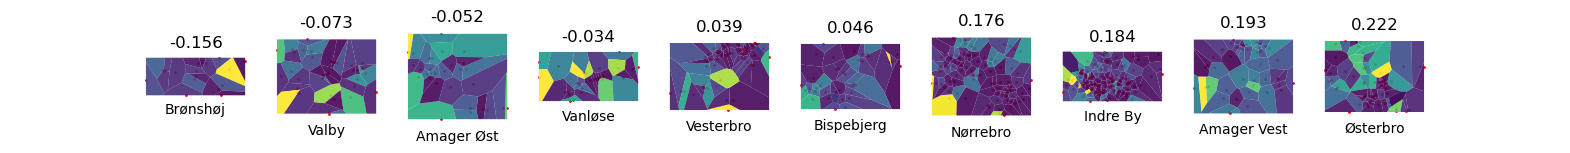

In [24]:
morans_plot_fn(gdf, bdf, adf, "aadt_koret")

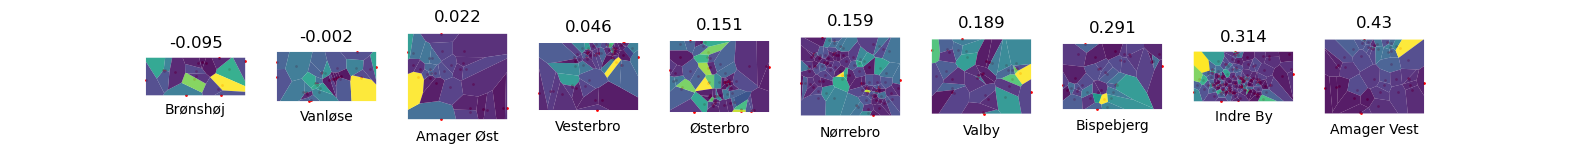

In [25]:
morans_plot_fn(gdf, bdf, adf, "aadt_cykle")

Although not entirely intended in the course, part of the visuals for these plots is done in "post-production" to insert the chess board analogy for better understanding for a non-technically minded audience and to include a scale to understand the value distribution. The final plots are shown below.

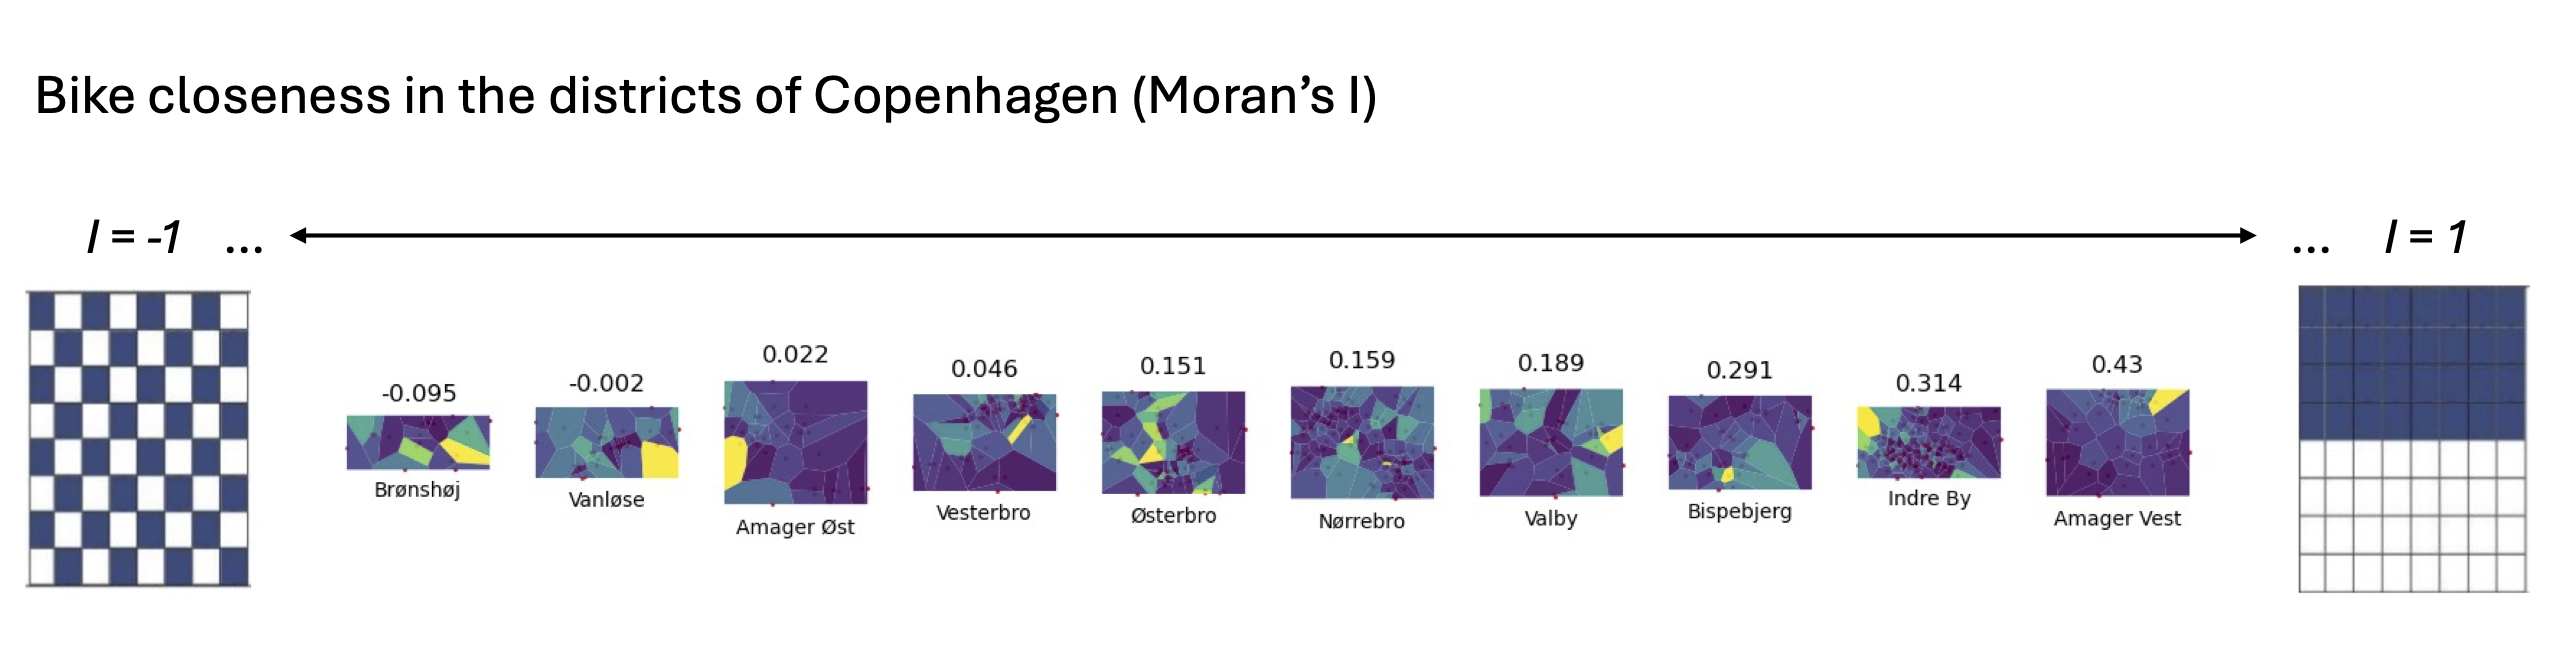

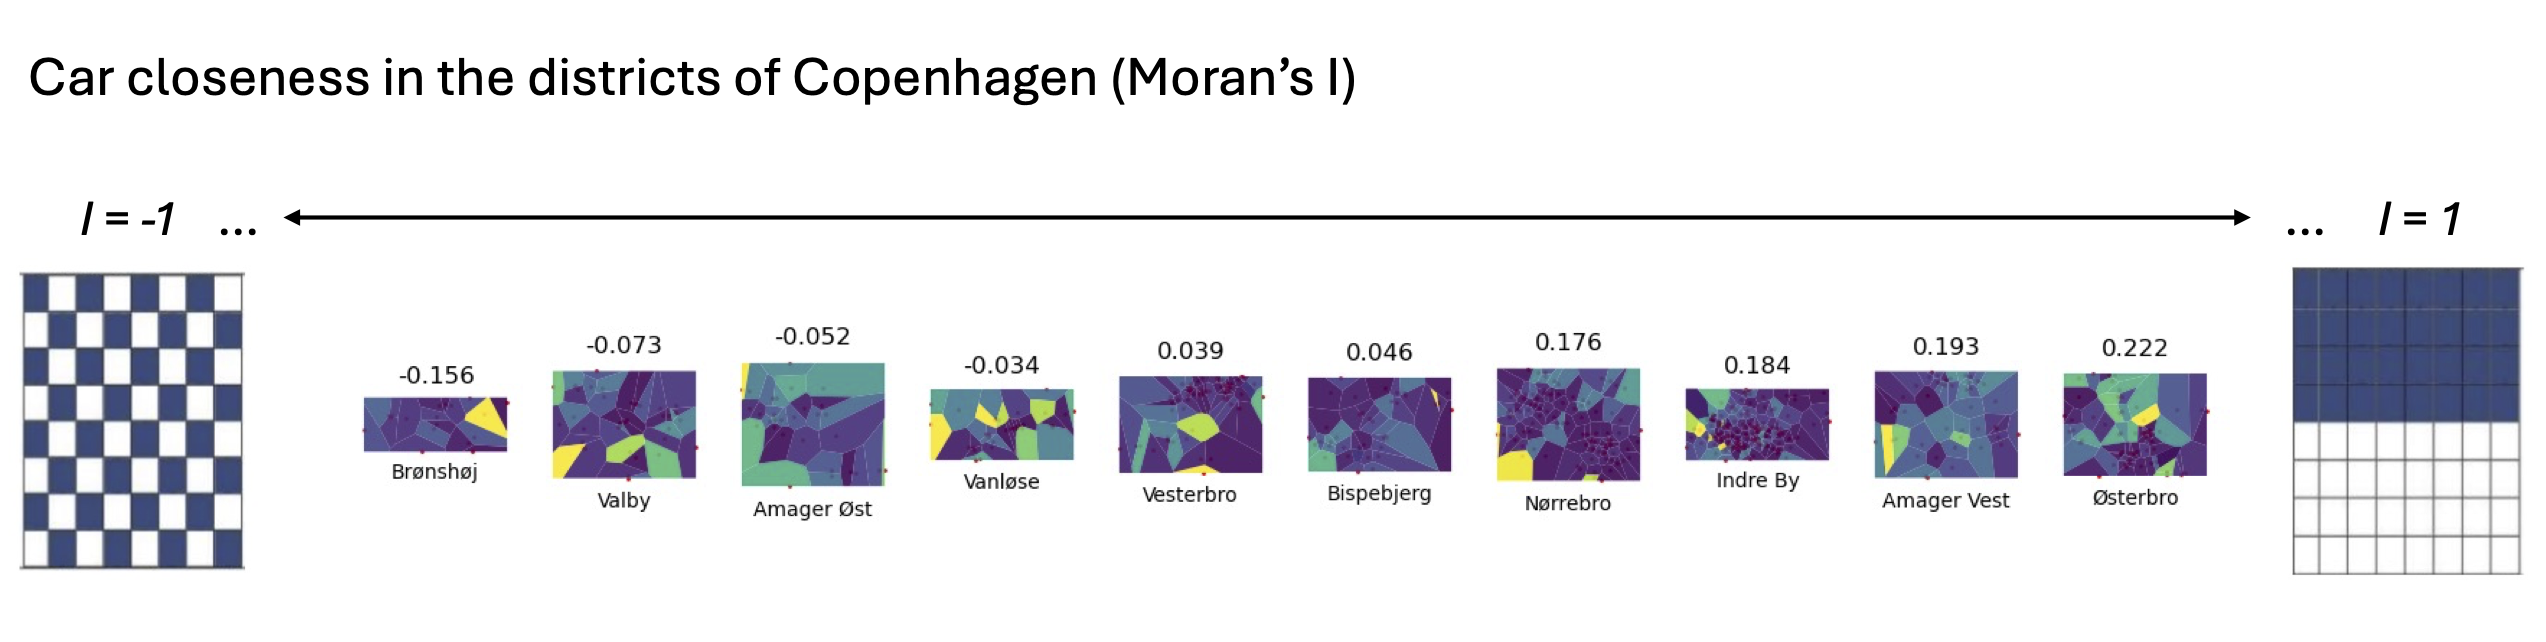

In [26]:
from PIL import Image
from IPython.display import display

img1 = Image.open('plots/morans_bikes.png')
img2 = Image.open('plots/morans_cars.png')

display(img1)
display(img2)

### Visual coherence

We use very different plot types (i.e., maps and charts), which we know create some visual inconsistency. To create the plots, we used three different libraries (matplotlib, bokeh, folium), which all have different esthetics. To make up for these inconsistencies and create visual coherence on the website, we made some deliberate design choices, e.g., muted greens and greyscale map and lines as connecting colors between all plots and placing all titles to the upper left. Visually, the plots are still very different, but the small connecting elements attempt to remove that distraction when putting them close together on the website.

## Discussion

The creations in this project are of varying quality. There are relevant things to unpack, which we will do in the following sections.

#### Dual plot line chart
This is perhaps the most easily understandable plot of them all. It still has some complexity in the dual y-axis, and in that the two plots combine different measures (count and mean). However, as line charts are widely used and easily understood, and because we have limited the data-ink to reduce visual clutter, we still find it very easy to read. The rest of the analysis presented is more complex, which is why we find it very effective to ease into the topic of traffic in Copenhagen with a chart that is easily accessible.

#### Interactive bar chart
The bar chart has some drawbacks. The number of categories displayed makes the plot crowded. The interactivity tries to account for this shortcoming, and in many cases, the filtering/highlighting does work well. However, some categories are assigned a very light color, and these become difficult to distinguish from others.

The interactivity also allows us to select more categories at once, which, in theory, is interesting. Still, due to the overcrowding, another filtration method might have been more appropriate for comparing categories.

Lastly, normalization has some strengths and weaknesses as well. On the one hand, it helps when comparing categories over time with very different counts of different orders of magnitude, as the normalization is on the same scale. On the other hand, the inability to compare the order of magnitude makes comparison difficult. The normalization assigns heavy weight to poorly represented means of transportation, e.g., the electric scooter, which is only recorded in the data set from 2019 onwards and has a low presence relative to other categories. To the untrained eye, it may seem as though electric scooters are the most used means of transportation in the city.

#### Moran's I plot 1 and 2
With the Moran's I analysis, we took a creative leap of faith. We are communicating to a non-technically minded audience that has likely never heard of this statistical measure before. Despite this, we thought spatial autocorrelation was an exciting aspect to investigate, which we had yet to see used in many other traffic analyses in Copenhagen.

As we argue when presenting the plot, Moran's I may not be representative when removing the time-series aspect. However, limitations in the data set do not allow us to do it otherwise. As argued earlier, the differences across times in terms of which streets are used for bolk commuting and which for sparse traffic are likely to stay the same within the period we observe. However, if one street with heavy traffic is observed many times over the years, it may result in higher Moran'I values for that district. This could have been accounted better for in pre-processing, although the quality of the analysis mainly requires more data from more observation points throughout the city.

Finally, we'll touch on some of Moran's I visualizations' shortcomings. The main challenge with the map is that it is often used to communicate cumulative counts in an area, whereas ours presents a sort of measure of closeness. This plot does not serve to explain the Moran's I measure but is to be understood in connection with the last plot. Therefore, we believe that the advantage of the spatial understanding outweighs the drawback.

As for the sorted plot of the tiles, we find that combining the analogy and scale with the measure gave a better understanding of Moran's I. Seeing the districts as squares might be challenging to understand at first, but is intended to present the real data in a way that allows the reader to explore our findings more and draw individual conclusions.

The plot is not intended to be understood through a brief glance, as would be the case in many news articles. Instead, it is intended for an audience already working in the area and therefore interested, which justifies the more challenging plot choice.

Whether the concept is understandable for the intended audience depends on the visualizations themselves *and* the explanatory text on the website presenting the Moran's I measure, which is why we chose the magazine style for the final product. There are indeed things to be improved in the visual coherence and layout of the plots. However, we still found it an exciting challenge to combine and find new visualization methods to present and communicate statistical content.

## Contributions

**Julius Olander, s203225**

Report:
- Introduction
- Basic stats
- Bokeh plot
- Discussion

Website:
- Story
- Research

**Astrid Machholm, s222228**

Report:
- Introduction
- Basic stats
- Analysis
- Genre
- Dual line chart
- Moran's I plot
- Discussion

Website:
- Story
- Setup